# IMAGE CLASSIFICATION

importing necessary libraries and Dependencies

In [12]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set all the Constants

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

# Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "seg_train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 17034 files belonging to 6 classes.


In [15]:
class_names = dataset.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [16]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 0 2 4 3 5 0 1 5 2 3 1 2 1 1 3 1 1 3 2 5 2 1 1 2 5 4 4 0 1 3 5]


every data we got as a tensor as we are using tf.dataset so we need to convert using numpy and take(1) means it is taking one batch i.e 32 images      (32,256,256,3) mean 32 images having sizes 256*256 and having color 3 i.e rgb.     each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

# Data Visualization

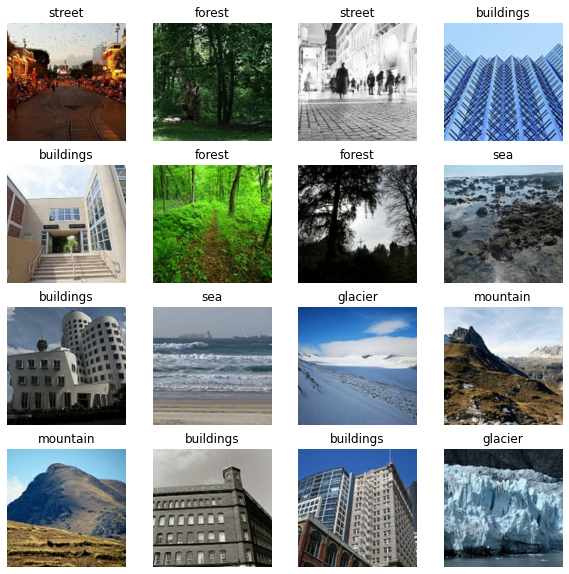

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
len(dataset)

533

it is showing 533 because it is devided into 32 batches so you can crosscheck by multiplying 32*439

In [19]:
32*533

17056

# Function to Split Dataset

Dataset should be distributed into 3 subsets, namely:

1.Training: Dataset to be used while training
2.Validation: Dataset to be tested against while training
3.Test: Dataset to be tested against after we trained a model

**my motive is that i will split my data as 80%,10% and 10%. 80% data is for training purpose and 10% is for testing purpose and remaining 10% of data is for data validation purpose**

In [20]:
train_size = 0.8
len(dataset)*train_size

426.40000000000003

In [21]:
train_ds = dataset.take(426)
len(train_ds)

426

In [22]:
test_ds = dataset.skip(426)
len(test_ds)

107

In [23]:
val_size=0.1
len(dataset)*val_size

53.300000000000004

In [24]:
val_ds = test_ds.take(53)
len(val_ds)

53

In [25]:
test_ds = test_ds.skip(53)
len(test_ds)

54

all the split we do in above sells all combinely together in below sell and suffle is true to get different data every times

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
len(train_ds)

426

In [29]:
len(test_ds)

54

In [30]:
len(val_ds)


53


# Cache, Shuffle, and Prefetch the Dataset

for impove our model and to reduce time complexity we use cache and prefetch. Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. here gpu and cpu runs together

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

# Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

In [33]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [34]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks**

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [36]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
426/426 [==============================] - 676s 2s/step - loss: 1.3286 - accuracy: 0.4487 - val_loss: 1.1597 - val_accuracy: 0.5407
Epoch 2/20
426/426 [==============================] - 669s 2s/step - loss: 1.1642 - accuracy: 0.5292 - val_loss: 1.0782 - val_accuracy: 0.5566
Epoch 3/20
426/426 [==============================] - 684s 2s/step - loss: 1.0751 - accuracy: 0.5824 - val_loss: 1.1476 - val_accuracy: 0.5702
Epoch 4/20
426/426 [==============================] - 623s 1s/step - loss: 1.0093 - accuracy: 0.6158 - val_loss: 1.0354 - val_accuracy: 0.6350
Epoch 5/20
426/426 [==============================] - 642s 2s/step - loss: 0.9692 - accuracy: 0.6324 - val_loss: 0.8607 - val_accuracy: 0.6804
Epoch 6/20
426/426 [==============================] - 632s 1s/step - loss: 0.9325 - accuracy: 0.6506 - val_loss: 0.8160 - val_accuracy: 0.6851
Epoch 7/20
426/426 [==============================] - 615s 1s/step - loss: 0.8814 - accuracy: 0.6694 - val_loss: 0.8077 - val_accuracy: 0.7081

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

 1/54 [..............................] - ETA: 33:34 - loss: 0.7628 - accuracy: 0.7188

In [70]:
scores

[0.784803032875061, 0.7034721970558167]

Now i want to play with history,here is all about history in tensorflow
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [71]:
history

In [72]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 351}

In [73]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [74]:
type(history.history['loss'])

list

In [75]:
len(history.history['loss'])#it shows the no of epoch

10

In [76]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.2044682502746582,
 1.1321555376052856,
 1.0618782043457031,
 0.9928975105285645,
 0.9653626084327698]

In [77]:
#assigning in variables to call easily further
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Ploting accuracy and loss for visualisation

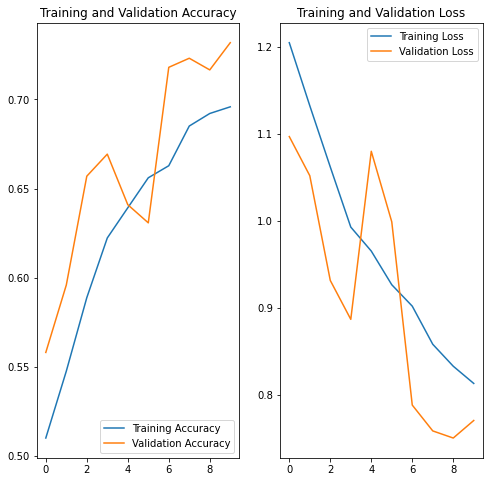

In [78]:
#it is ploting training as well as validation
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

predict one image which is first image of the batch 1

first image to predict
actual label: buildings
1/1 [==============================] - 1s 1s/step
predicted label: street


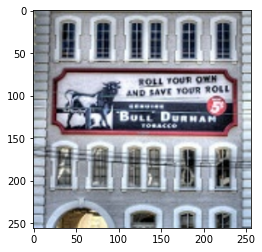

In [79]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    #np.argmax is used to get the maximum probability

# creating a function which take image and model, and predict the class and confidence

In [80]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


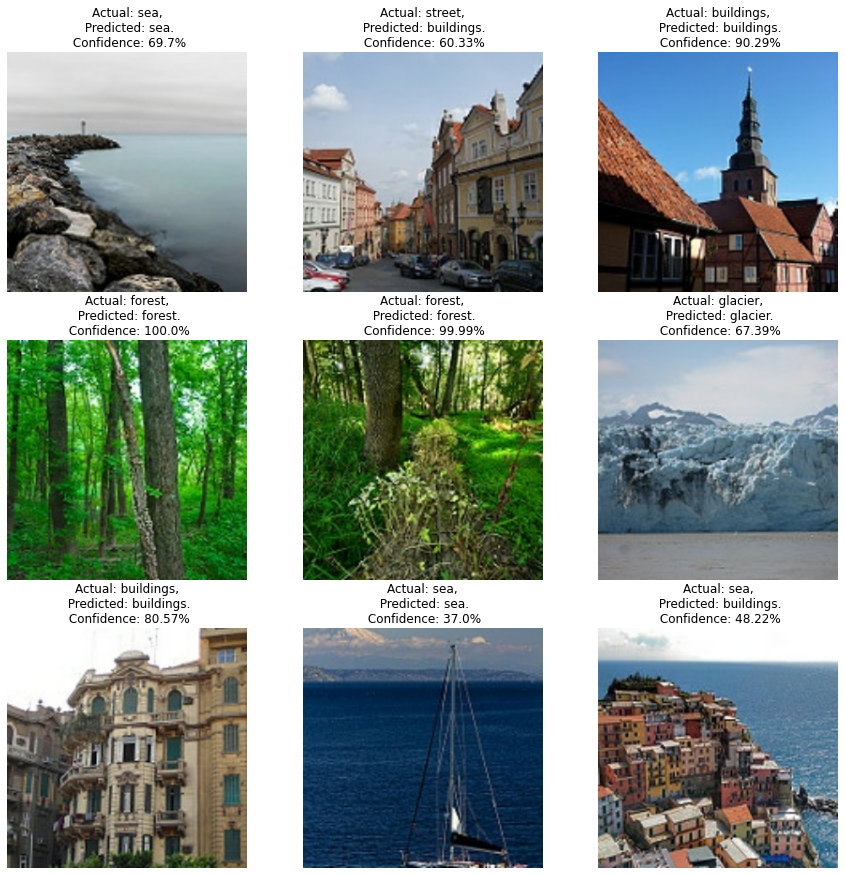

In [84]:
# ploting this images with prediction

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


# Saving our Model

In [85]:
model.save("../models/")

INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


In [88]:
model_version =1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
